## Load Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt 

In [2]:
'''
Likelihood of default dataset: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset
'''
def load_credit(path="taiwan_credit.csv", standardize=True):
    credit = pd.read_csv(path)
    
    mutable_feats = ['EducationLevel', 'MaxBillAmountOverLast6Months', 'MaxPaymentAmountOverLast6Months',
       'MonthsWithZeroBalanceOverLast6Months',
       'MonthsWithLowSpendingOverLast6Months',
       'MonthsWithHighSpendingOverLast6Months', 'MostRecentBillAmount',
       'MostRecentPaymentAmount', 'TotalOverdueCounts', 'TotalMonthsOverdue',
       'HistoryOfOverduePayments']
    
    X = credit[mutable_feats].to_numpy()
    X_std = X
    if standardize:
        scaler = StandardScaler()
        X_std = scaler.fit_transform(X)
    
    y = credit["NoDefaultNextMonth"].to_numpy().astype("int")
    return X_std, y

In [3]:
X_full, y_full = load_credit()

In [4]:
'''
Train model that generates f
'''
clf_gold = LogisticRegression(penalty='l2', max_iter=3000, 
                              solver="saga").fit(X_full, y_full)

## Split Data

In [5]:
'''
Number of transactions will be DATA_SIZE
Rest will be held out data for training the model that predicts S
'''
DATA_SIZE = 1000
random_idxs = np.random.permutation(range(len(X_full)))
train_idx = random_idxs[DATA_SIZE:]
test_idx = random_idxs[:DATA_SIZE]

In [6]:
X_tr = X_full[train_idx]
y_tr = y_full[train_idx]
X = X_full[test_idx]
y = y_full[test_idx]

## Training Model

In [7]:
'''
Fraction of held out data used to train model that outputs S
'''
TRAIN_FRAC = 0.05
TRAIN_SIZE = int(TRAIN_FRAC * len(X_tr))
TRAIN_SIZE

1450

In [8]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', max_iter=3000).fit(X_tr[:TRAIN_SIZE], y_tr[:TRAIN_SIZE])

## Compute S, f, M

In [9]:
S = clf.predict_proba(X)[:,1]
f = clf_gold.predict_proba(X)[:,1]

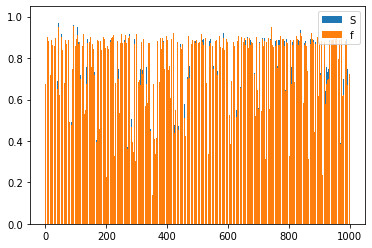

In [10]:
'''
On average how far is S from f
'''
np.average(np.abs(S - f))
import matplotlib.pyplot as plt 
plt.bar(x=np.arange(len(S)), height=S, label='S')
plt.bar(x=np.arange(len(f)), height=f, label='f')
plt.legend()
plt.show()

In [11]:
'''
Randomly generate M \in [100, 1000]
'''
M = np.random.random(DATA_SIZE) * (1000 - 100) + 100

In [12]:
N = DATA_SIZE

In [13]:
Pi = M/M.sum() 
m_star = np.sum(Pi*f) 
a = min(S)
a

0.021161517515034388

In [14]:
max_f_S_ratio = 1/a # the extreme case when f=1 and S=a

### Generate the data 

We generate a total of $N=N_1+N_2$ transactions from a bimodal distribution. In particular, we have     
* $N_1$ transactions with $M$-values in the range $[100, 1000]$  and $f$-values in the range $[0.4, 0.5]$ 
* $N_2$ transactions with $M$-values in the range $[10^5, 2\times 10^5]$ and $f$-values in the range $[10^{-1}, 2\times 10^{-1}]$. 

Finally, we generate $S$ values (that is $[0,1]$ valued prediction from Neptune scores) randomly satisfying 
$$
a \leq \frac{S}{f} \leq 2-a, 
$$
with $a=0.1$.

### Construct the CS 
To construct the CS (in the batch setting), we only need to specify the sampling methods. Any sampling method must take in as inputs two arrays: `M` and `S`, and return one array `SW` of the same size. Examples: 
* `propM(M, S) = M`
* `propMS(M, S) = M*S`
* `propMinv(M, S)= 1/M` 

The confidence sequence (CS) for each method is constructed by calling the `get_conf_seq` function.

In [15]:
from weightedCS import generate_MFS, get_sampling_weights, get_conf_seq, sample_indices 
from utils import plot_results1
import numpy as np 

In [16]:
# define the sampling methods 
propM = lambda M, S: M 
propMS = lambda M, S: M*S 
propMinv = lambda M, S: M**(-1)
Methods = [propM, propMS, propMinv]
# assign then names (in the same order as Methods list)
method_names = ['propM', 'propMS', 'propMinv'] 
# initialize the dictionaries to store the lower and upper CSs
LowerCSdict, UpperCSdict = {}, {}
# initialize the grid of possible m-values for which the wealth process will be constructed
grid = np.linspace(0, 1, 100)
# the main loop 
for i, method_name in enumerate(method_names): 
    method = Methods[i]
    # get the weights assigned by the different sampling methods to the different transactions
    SW = get_sampling_weights(M, S, method=method)
    # get the sequence of indices sampled proportional to SW without replacement
    Idx = sample_indices(N, SamplingWeights=SW) 

    use_propMS = method_name=='propMS' #TODO: remove this hardcoding
    # obtain the lower and upper confidence sequences    
    LowerCS, UpperCS, _, _, _ = get_conf_seq(f, Pi, S, Idx, grid, SW,
                use_propMS=use_propMS, max_lambda_val=2.0, betting_method='kelly', 
                max_f_S_ratio=max_f_S_ratio, threshold=40, intersect=True)
    # store in the dicts 
    LowerCSdict[method_name] = LowerCS
    UpperCSdict[method_name] = UpperCS


### Plot the results 

/home/sshekhar17/Codes/AuditingNew/src/utils.py:267: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(bottom=0, top=max(M)*1.3)


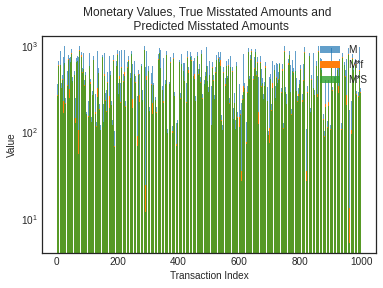

<Figure size 432x288 with 0 Axes>

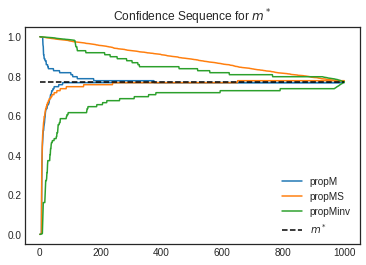

In [17]:
plot_results1(N, M, f, S, method_names, LowerCSdict, UpperCSdict, 
                    palette=None, save_fig=False, figname=None)


In [18]:
# First generate the data 
N1, N2  = 200, 300
N = N1+N2
N_vals = [N1, N2]
M_ranges = [ [1e2, 1e3], [1e5, 2*1e5]] 
f_ranges = [[0.4, 0.5], [1e-1, 2*1e-1]] 
a = 0.1
max_f_S_ratio = 1/a # the extreme case when f=1 and S=a

M, f, S = generate_MFS(N_vals=N_vals, N=N, M_ranges=M_ranges, f_ranges=f_ranges, a=a)

Pi = M/M.sum() 
m_star = np.sum(Pi*f)